In [67]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
sn.set_style("whitegrid")
import sympy as sym
import scipy as sci
#import pycollocation
#import pyam

In [69]:
from estimation_Julia import *

In [5]:
# should be 0.4.0a0
pycollocation.__version__

NameError: name 'pycollocation' is not defined

In [71]:
# should be 0.2.0a0
pyam.__version__

'0.2.2a0'

In [11]:
arr = np.arange(6).reshape(2, 3)
np.place(arr, arr>1, -99)
arr**2

array([[   0,    1, 9801],
       [9801, 9801, 9801]])

In [72]:
jucla = Julia_Estimation()

In [73]:
with open('forestimation.csv', 'rb') as f:
    reader = csv.reader(f)
    data = list(reader)

theta_data = []
wage_data = []
profit_data = []
wgt_data= []
c = 0
fr = 1
for row in data[fr:]:
    theta_data.append(float(row[1-c]))
    wage_data.append(float(row[2-c]))
    profit_data.append(float(row[3-c]))
    wgt_data.append(float(row[4-c]))

theta_data = np.log(np.array(theta_data))
# Daily LOG average wage for each firm, in euros (float)
wage_data = np.log(np.array(wage_data))
# Declared LOG average profits for each firm per year, in euros (float)
profit_data = np.log(np.array(profit_data))    
wage_data = np.log(np.exp(wage_data)*360) # ANNUAL wage
wgt_data = wgt_data/np.sum(wgt_data)


#jucla.import_data('forestimation.csv', ID=True, weights=True, logs=False,yearly_w=True, change_weight=False, dummy=False, 
 #           labels=True)
#theta_data,wage_data,profit_data,wgts_data  = jucla.data

In [74]:
# positive assortativity requires that sigma_A * sigma_B < 1
#F_params = {'omega_A':0.3, 'omega_B':0.7, 'sigma_A':0.7, 'sigma_B':1.0 , 'Big_A':1.12}
F_params = {'omega_A':0.4, 'omega_B':0.65, 'sigma_A':0.9, 'sigma_B':1.0 , 'Big_A':5.06956549}



#F_params = {'omega_A':0.0307315, 'omega_B':0.24014643, 'sigma_A':0.83177002, 'sigma_B':1.0 , 'Big_A':5.06956549}
#F_params = {'omega_A':0.0307315, 'omega_B':0.24014643, 'sigma_A': 0.83177002 , 'Big_A': 5.06956549}



## Defining inputs

Need to define some heterogenous factors of production...

In [148]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': 1e0, 'mu1': 0.0, 'sigma1': 1.1}

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=(1.2, 1e1),  # guesses for the alpha and (1 - alpha) quantiles!
                     alpha=0.0005,
                     measure=16.0  # 15x more workers than firms
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 0.95}

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=(1.2, 1e1),  # guesses for the alpha and (1 - alpha) quantiles!
                   alpha=0.0005,
                   measure=1.0
                   )

Note that we are shifting the distributions of worker skill and firm productivity to the right by 1.0 in order to try and avoid issues with having workers (firms) with near zero skill (productivity).

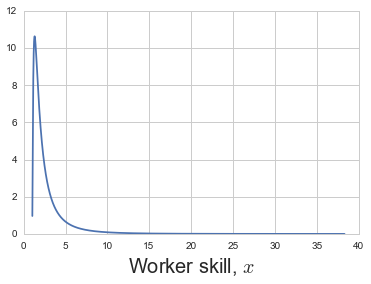

In [149]:
xs = np.linspace(workers.lower, workers.upper, 1e4)
plt.plot(xs, workers.evaluate_pdf(xs))
plt.xlabel('Worker skill, $x$', fontsize=20)
plt.show()

## Defining a production process

Next need to define some production process...

In [150]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B, Big_A = sym.var('r, l, omega_B, sigma_B, Big_A')
B = l**omega_B * r**(1 - omega_B)*Big_A*100000
F = A * B

## Define a boundary value problem

In [151]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=F,
                                          F_params=F_params)

## Pick some collocation solver

In [152]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess
Currently I guess that $\mu(x)$ is has the form...

$$ \hat{\mu}(x) = \beta_0 + \beta_1 f(x) $$

(i.e., a linear translation) of some function $f$.  Using my $\hat{\mu}(x)$, I can then back out a guess for $\theta(x)$ implied by the model...

$$ \hat{\theta}(x) = \frac{H(x)}{\hat{\mu}'(x)} $$

In [153]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 55, 'theta': 55},
                                                    f=lambda x, alpha: x**alpha,
                                                    alpha=0.0001)

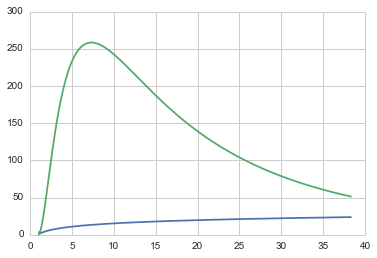

In [154]:
# quickly plot the initial conditions
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [155]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [156]:
solver.result.success

True

## Plot some results

In [157]:
viz = pyam.Visualizer(solver)

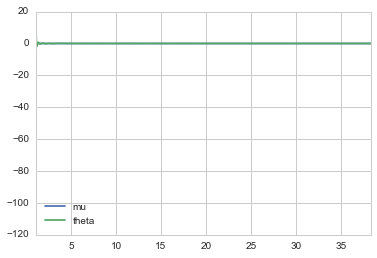

In [158]:
viz.interpolation_knots = np.linspace(workers.lower, workers.upper, 1000)
viz.residuals.plot()
plt.show()

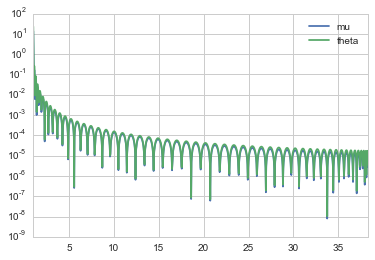

In [159]:
viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
plt.show()

In [160]:
viz.solution.tail()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
38.172537,6.481058e+08,1903125.473587,666093.915755,2.268370e+08,6792397.833655,19945.487415,2377339.241779,118334.449783,10161936.431314,29839.944622,3556677.750960,1903125.473587,2.268370e+08,38.262658,221.356265
38.209870,6.485373e+08,1904270.901383,666494.815484,2.269880e+08,6790012.748440,19937.209736,2376504.461954,118250.063876,10165020.223034,29847.092732,3557757.078062,1904270.901383,2.269880e+08,38.277521,221.370410
38.247202,6.489679e+08,1905415.823263,666895.538142,2.271388e+08,6787622.644522,19928.941823,2375667.925583,118165.764641,10168097.621055,29854.256277,3558834.167369,1905415.823263,2.271388e+08,38.292347,221.384294
38.284535,6.493973e+08,1906560.147386,667296.051585,2.272890e+08,6785223.424706,19920.682172,2374828.198647,118081.528546,10171166.884573,29861.445989,3559908.409601,1906560.147386,2.272890e+08,38.307123,221.397801
38.321867,6.498258e+08,1907703.986224,667696.395179,2.274390e+08,6782820.091015,19912.432559,2373987.031855,117997.383764,10174230.136523,29868.648839,3560980.547783,1907703.986224,2.274390e+08,38.321867,221.411073


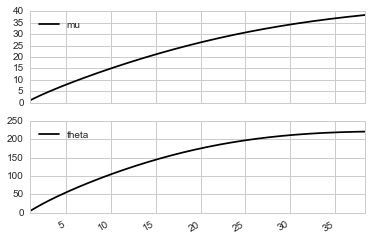

In [161]:
viz.solution[['mu', 'theta']].plot(subplots=True)
#plt.show()
mytest = viz.solution[['mu','theta']].values
#plt.plot(mytest)
#mytest
#np.size?

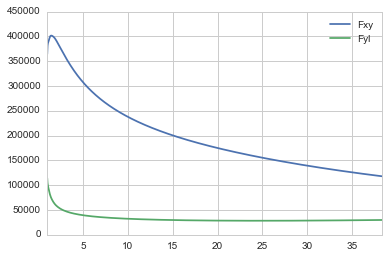

In [162]:
viz.solution[['Fxy', 'Fyl']].plot()
plt.show()

## Plot factor payments
Note the `factor_payment_1` is wages and `factor_payment_2` is profits...

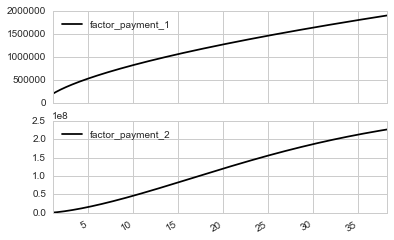

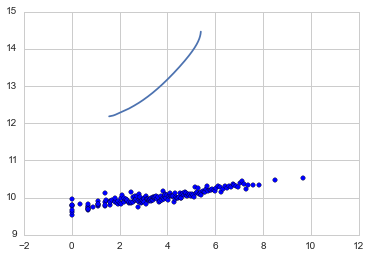

In [163]:
viz.solution[['factor_payment_1', 'factor_payment_2']].plot(subplots=True)
plt.show()
wage_sol = viz.solution[['factor_payment_1']].values
theta_sol = viz.solution[['theta']].values
plt.scatter(theta_data,wage_data)
plt.plot(np.log(theta_sol),np.log(wage_sol))

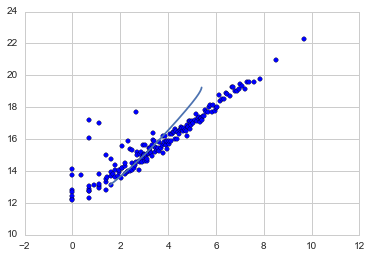

In [164]:
profit_sol = viz.solution[['factor_payment_2']].values
plt.scatter(theta_data,profit_data)
plt.plot(np.log(theta_sol),np.log(profit_sol))



## Plot firm size against wages and profits

30


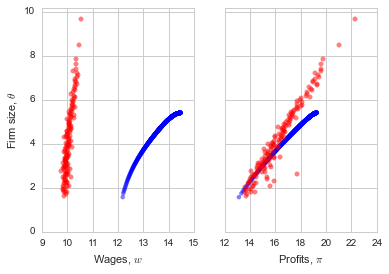

[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.40000000e+00
   2.00000000e+00   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00   2.00000000e+00   2.45000000e+00
   3.00000000e+00   3.00000000e+00   3.00000000e+00   3.00000000e+00
   3.00000000e+00   4.00000000e+00   4.00000000e+00   4.00000000e+00
   4.00000000e+00   4.20000000e+00   5.00000000e+00   5.00000000e+00
   5.00000000e+00   5.00000000e+00   5.45000000e+00   6.00000000e+00
   6.00000000e+00   6.00000000e+00   6.60000000e+00   7.00000000e+00
   7.00000000e+00   7.60000000e+00   8.00000000e+00   8.00000000e+00
   8.05000000e+00   9.00000000e+00   9.00000000e+00   9.00000000e+00
   9.75000000e+00   1.00000000e+01   1.00000000e+01   1.10000000e+01
   1.10000000e+01   1.18500000e+01   1.20000000e+01   1.21500000e+01
   1.30000000e+01   1.30000000e+01   1.39000000e+01   1.40000000e+01
   1.42000000e+01   1.50000000e+01

In [165]:
cutoff = len(theta_data[np.exp(theta_data)<5])
print cutoff

theta_plot = np.log(viz.solution.theta)
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(np.log(viz.solution.factor_payment_1), theta_plot, alpha=0.5,
               edgecolor='none')
axes[0].scatter(wage_data[cutoff-1:len(wage_data)], theta_data[cutoff-1:len(wage_data)], alpha=0.5,
               edgecolor='red',color='red')
axes[0].set_ylim(0, 1.05 * theta_data.max())
axes[0].set_xlabel('Wages, $w$')
axes[0].set_ylabel(r'Firm size, $\theta$')

axes[1].scatter(np.log(viz.solution.factor_payment_2), theta_plot, alpha=0.5,
               edgecolor='none')
axes[1].scatter(profit_data[cutoff-1:len(wage_data)], theta_data[cutoff-1:len(wage_data)], alpha=0.5,
               edgecolor='red',color='red')
axes[1].set_xlabel(r'Profits, $\pi$')

plt.show()
print np.exp(theta_data[0:len(wage_data)])

In [166]:
# to get correlation just use pandas!
viz.solution.corr()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
F,1.000000,0.991166,0.991166,1.000000,0.813519,-0.854047,0.813519,-0.925114,0.971802,-0.575907,0.971802,0.991166,1.000000,0.986791,0.962666
Fl,0.991166,1.000000,1.000000,0.991166,0.877791,-0.913783,0.877791,-0.966200,0.993314,-0.667837,0.993314,1.000000,0.991166,0.998116,0.985762
Flr,0.991166,1.000000,1.000000,0.991166,0.877791,-0.913783,0.877791,-0.966200,0.993314,-0.667837,0.993314,1.000000,0.991166,0.998116,0.985762
Fr,1.000000,0.991166,0.991166,1.000000,0.813519,-0.854047,0.813519,-0.925114,0.971802,-0.575907,0.971802,0.991166,1.000000,0.986791,0.962666
Fx,0.813519,0.877791,0.877791,0.813519,1.000000,-0.979355,1.000000,-0.965860,0.926865,-0.875800,0.926865,0.877791,0.813519,0.896730,0.939224
Fxl,-0.854047,-0.913783,-0.913783,-0.854047,-0.979355,1.000000,-0.979355,0.979778,-0.948291,0.900625,-0.948291,-0.913783,-0.854047,-0.921218,-0.947281
Fxr,0.813519,0.877791,0.877791,0.813519,1.000000,-0.979355,1.000000,-0.965860,0.926865,-0.875800,0.926865,0.877791,0.813519,0.896730,0.939224
Fxy,-0.925114,-0.966200,-0.966200,-0.925114,-0.965860,0.979778,-0.965860,1.000000,-0.987155,0.796037,-0.987155,-0.966200,-0.925114,-0.972616,-0.987009
Fy,0.971802,0.993314,0.993314,0.971802,0.926865,-0.948291,0.926865,-0.987155,1.000000,-0.729309,1.000000,0.993314,0.971802,0.996937,0.997717
Fyl,-0.575907,-0.667837,-0.667837,-0.575907,-0.875800,0.900625,-0.875800,0.796037,-0.729309,1.000000,-0.729309,-0.667837,-0.575907,-0.678647,-0.729091


In [131]:
# or a subset
viz.solution[['theta', 'factor_payment_1','factor_payment_2']].corr()

,theta,factor_payment_1,factor_payment_2
theta,1.000000,0.932539,0.930955
factor_payment_1,0.932539,1.000000,0.995448
factor_payment_2,0.930955,0.995448,1.000000


In [132]:
print viz.solution[['theta', 'factor_payment_1','factor_payment_2']].mean()
print viz.solution[['theta', 'factor_payment_1','factor_payment_2']].max()
viz.solution[['theta', 'factor_payment_1','factor_payment_2']].min()

theta               1.582856e+02
factor_payment_1    1.250698e+06
factor_payment_2    1.203568e+08
dtype: float64
theta               2.032172e+02
factor_payment_1    1.986471e+06
factor_payment_2    2.109758e+08
dtype: float64


theta                    4.456144
factor_payment_1    200554.158611
factor_payment_2    481222.098125
dtype: float64

In [133]:
print np.mean(np.exp(theta_data[cutoff-1:len(wage_data)])),np.mean(np.exp(wage_data[cutoff-1:len(wage_data)])), np.mean(np.exp(profit_data))
print np.max(np.exp(theta_data[cutoff-1:len(wage_data)])),np.max(np.exp(wage_data[cutoff-1:len(wage_data)])), np.max(np.exp(profit_data[cutoff-1:len(wage_data)]))
print np.min(np.exp(theta_data[cutoff-1:len(wage_data)])),np.min(np.exp(wage_data[cutoff-1:len(wage_data)])), np.min(np.exp(profit_data[cutoff-1:len(wage_data)]))

345.228231293 23644.6638367 68274480.4716
15792.3 37353.24 4800000000.0
5.0 17277.408 783675.0


In [134]:
#print np.corrcoef(np.exp(theta_data),np.exp(wage_data))
slope, intercept, r_value, p_value, std_err = stats.linregress(theta_data,wage_data)
print slope,intercept, r_value, p_value, std_err

0.0817180108999 9.71789553502 0.906305883071 5.48225106461e-67 0.00288882223985


In [135]:
print np.corrcoef(np.exp(theta_data),np.exp(profit_data))
slope, intercept, r_value, p_value, std_err = stats.linregress(theta_data,profit_data)
print slope,intercept, r_value, p_value, std_err

[[ 1.         0.9928658]
 [ 0.9928658  1.       ]]
0.918932807613 12.4969355452 0.936216090541 6.08372861044e-81 0.0261496277903


In [136]:
print np.corrcoef(wage_data,profit_data)
slope, intercept, r_value, p_value, std_err = stats.linregress(wage_data,profit_data)
print slope,intercept, r_value, p_value, std_err

[[ 1.          0.87416307]
 [ 0.87416307  1.        ]]
9.51605895376 -79.4643587024 0.874163070955 1.80400651489e-56 0.400772383691


In [137]:
# or actual values!
viz.solution.corr().loc['theta']['factor_payment_1']

0.93253874895531164

## Plot the density for firm size

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$pdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $pdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

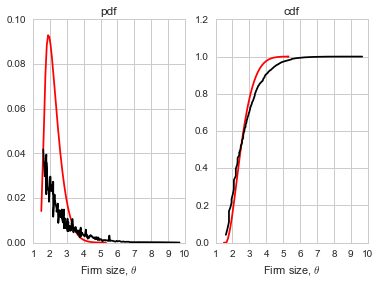

In [138]:
cdf_theta_data = np.cumsum(wgt_data[cutoff-1:len(wage_data)])/np.sum(wgt_data[cutoff-1:len(wage_data)])
pdf_theta_data = wgt_data[cutoff-1:len(wage_data)]/np.sum(wgt_data[cutoff-1:len(wage_data)])




fig, axes = plt.subplots(1, 2)
theta_pdf = viz.compute_pdf('theta', normalize=True)
axes[0].plot(np.log(theta_sol),theta_pdf,color='red')
axes[0].plot(theta_data[cutoff-1:len(wage_data)],pdf_theta_data,color='black')
#axes[0].plot(cdf_theta_data)
#theta_pdf.plot(ax=axes[0])
axes[0].set_xlabel(r'Firm size, $\theta$')
axes[0].set_title(r'pdf')

theta_cdf = viz.compute_cdf(theta_pdf)
#theta_cdf.plot(ax=axes[1])
axes[1].plot(np.log(theta_sol),theta_cdf,color = 'red')
axes[1].plot(theta_data[cutoff-1:len(wage_data)], cdf_theta_data,color = 'black')
axes[1].set_title(r'cdf')
axes[1].set_xlabel(r'Firm size, $\theta$')

#theta_sf = viz.compute_sf(theta_cdf)
#theta_sf.plot(ax=axes[2])
#axes[2].set_title(r'sf')
#axes[2].set_xlabel(r'Firm size, $\theta$')

#plt.tight_layout()
plt.show()



## Distributions of factor payments

Can plot the distributions of average factor payments...

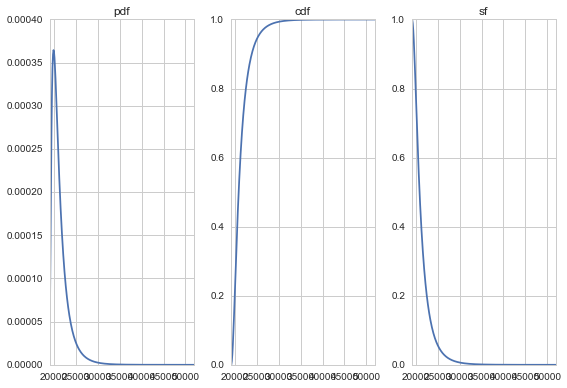

In [84]:
fig, axes = plt.subplots(1, 3)
factor_payment_1_pdf = viz.compute_pdf('factor_payment_1', normalize=True)
factor_payment_1_pdf.plot(ax=axes[0])
axes[0].set_title(r'pdf')

factor_payment_1_cdf = viz.compute_cdf(factor_payment_1_pdf)
factor_payment_1_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')

factor_payment_1_sf = viz.compute_sf(factor_payment_1_cdf)
factor_payment_1_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

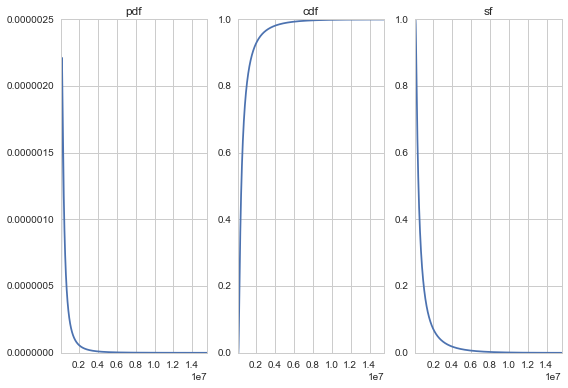

In [85]:
fig, axes = plt.subplots(1, 3)
factor_payment_2_pdf = viz.compute_pdf('factor_payment_2', normalize=True)
factor_payment_2_pdf.plot(ax=axes[0])
axes[0].set_title(r'pdf')

factor_payment_2_cdf = viz.compute_cdf(factor_payment_2_pdf)
factor_payment_2_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')

factor_payment_2_sf = viz.compute_sf(factor_payment_2_cdf)
factor_payment_2_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

## Widget

In [86]:
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [116]:
def interactive_plot(viz, omega_A=0.25, omega_B=0.5, sigma_A=0.5, sigma_B=1.0, Big_A=1.5,
                     loc1=1.0, mu1=0.0, sigma1=1.0, loc2=1.0, mu2=0.0, sigma2=1.0):
    # update new parameters as needed
    new_F_params = {'omega_A': omega_A, 'omega_B': omega_B,
                    'sigma_A': sigma_A, 'sigma_B': sigma_B,
                   'Big_A': Big_A}
    viz.solver.problem.F_params = new_F_params
    
    new_input1_params = {'loc1': loc1, 'mu1': mu1, 'sigma1': sigma1}
    viz.solver.problem.input1.params = new_input1_params
    
    new_input2_params = {'loc2': loc2, 'mu2': mu2, 'sigma2': sigma2}
    viz.solver.problem.input2.params = new_input2_params
    
    # solve the model using a hotstart initial guess
    domain = [viz.solver.problem.input1.lower, viz.solver.problem.input1.upper]
    initial_coefs = viz.solver._coefs_array_to_dict(viz.solver.result.x, viz.solver.degrees)
    viz.solver.solve(kind="Chebyshev",
                     coefs_dict=initial_coefs,
                     domain=domain,
                     method='hybr')
    
    if viz.solver.result.success:
        viz._Visualizer__solution = None  # should not need to access this!
        viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
        #viz.solution[['mu', 'theta']].plot(subplots=True)
        axes[0].scatter(wage_data,theta_data)
        axes[0].plot(np.log(viz.solution[['factor_payment_1']]),np.log(viz.solution[['theta']]))
        plt.show()
        viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
        
    else:
        print("Foobar!")

In [117]:
viz_widget = widgets.fixed(viz)

# widgets for the model parameters
eps = 1e-2
omega_A_widget = widgets.FloatSlider(value=0.25, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_A$")
sigma_A_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\sigma_A$")
omega_B_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_B$")
Big_A_widget = widgets.FloatSlider(value=1.5, min=1+eps, max=2-eps,step=eps,
                                  description=r"$Big_A$")
sigma_B_widget = widgets.fixed(1.0)

# widgets for input distributions
loc_widget = widgets.fixed(1.0)
mu_1_widget = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=eps,
                                  description=r"$\mu_1$")
mu_2_widget = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=eps,
                                  description=r"$\mu_2$")
sigma_1_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_1$")
sigma_2_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_2$")


<function __main__.interactive_plot>

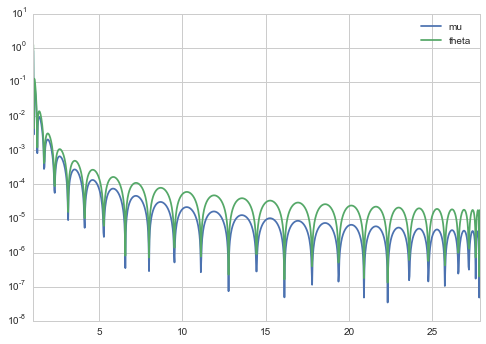

In [118]:
widgets.interact(interactive_plot, viz=viz_widget, omega_A=omega_A_widget,
                 sigma_A=sigma_A_widget, omega_B=omega_B_widget,
                 sigma_B=sigma_B_widget, Big_A = Big_A_widget, sigma1=sigma_1_widget,
                 loc1=loc_widget, mu1 = mu_1_widget, 
                 loc2=loc_widget, sigma2=sigma_2_widget, mu2 = mu_2_widget)

In [112]:
# widget is changing the parameters of the underlying solver
solver.result.x

array([  1.74387485e+01,   1.34066796e+01,  -3.15796438e+00,
         3.35435319e-02,   1.62746315e-01,  -2.03501121e-02,
        -7.39765196e-03,  -1.62060414e-03,   5.03532307e-03,
        -4.16902723e-03,   3.14061303e-03,  -2.48847809e-03,
         1.95162166e-03,  -1.46504473e-03,   1.04955358e-03,
        -7.10170777e-04,   4.37946881e-04,  -2.22708091e-04,
         5.58370615e-05,   7.00571781e-05,  -1.61246406e-04,
         2.22699257e-04,  -2.57844925e-04,   2.69572424e-04,
        -2.64305555e-04,   1.26798944e-04,   5.23290194e+01,
         2.64201373e+01,  -1.41601625e+01,   3.80077078e+00,
        -1.02143380e+00,   5.37928933e-01,  -2.98250108e-01,
         1.20771835e-01,  -3.01798566e-02,  -6.38896598e-03,
         1.97076501e-02,  -2.30054773e-02,   2.15113104e-02,
        -1.79722934e-02,   1.39253244e-02,  -1.01095883e-02,
         6.81562623e-03,  -4.11722792e-03,   1.98994405e-03,
        -3.68984988e-04,  -8.21326271e-04,   1.65243357e-03,
        -2.18328020e-03,